In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
from scipy import signal
from astropy.io import fits
from sklearn.decomposition import FastICA, PCA
from scipy.stats import pearsonr as pear
from PIL import Image, ImageDraw

In [2]:
in_path_fg = "fits_files/"
in_path_cs = "Boxes/"

output_path = "FastICA_different_noise/"
fname_all = "test_filename"

fname_foreground = "fg_all"
fname_cs = "test"

ncomp = 3
#1000 hours of noise
#noise = fits.getdata(r'fits_files/noise_108.000MHz_210.300MHz_SKA_SKA_central_area_EOR0_0128_3.0_1000h_K.fits')
#100 hours
#noise = fits.getdata('fits_files/Noise_100.fits').T
#10000 hours
noise  = fits.getdata('fits_files/Noise_10000.fits').T

indata_fg = fits.getdata(in_path_fg+fname_foreground+'.fits').T
indata_fg = indata_fg + noise

indata_cs = fits.getdata(in_path_cs+fname_cs+'.fits')
indata_cs = indata_cs/1000
sh = indata_cs.shape
print(sh)
print(indata_cs.shape)
no_sl = 342

(342, 128, 128)
(342, 128, 128)


## Plot model and foregrounds input

In [3]:
#code for fastICA
indata = indata_fg+indata_cs
#indata = indata_all
cube_data_name = "ZT0.msn_image"

sh = indata.shape
print(sh)
X = np.reshape(indata,(sh[0], sh[1]*sh[2]))

ica1 = FastICA(n_components=ncomp)
model1 = []
S = ica1.fit_transform(X.T)  # Reconstruct signals
A = ica1.mixing_  # Get estimated mixing matrix

model1 = np.reshape(np.matmul(A,S.T),(sh[0], sh[1],sh[2]))

res =  indata-model1
fits.writeto(output_path+cube_data_name+'_ncomp_'+str(ncomp)+'_FastICA_residual_10000.fits',res,overwrite='true')

rec =  indata-res
#fits.writeto(output_path+cube_data_name+'_ncomp_'+str(ncomp)+'_FastICA_model_10000.fits',rec,overwrite='true')
print("here")
#print(pear(rec,indata_fg)) Runs VERY slow

(342, 128, 128)
here


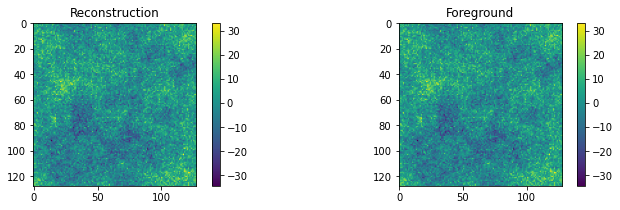

In [4]:
fig = plt.figure(figsize=(12,3))
ax = fig.add_subplot(1,2,1)
im0 = ax.imshow(np.real(rec[45,:,:]))
ax.title.set_text('Reconstruction')
fig.colorbar(im0,ax=ax)
clim=im0.properties()['clim']

ax = fig.add_subplot(1,2,2)
im = ax.imshow(indata_fg[45,:,:])
ax.title.set_text('Foreground')
fig.colorbar(im,ax=ax)
clim=im0.properties()['clim']
plt.show()
plt.close()



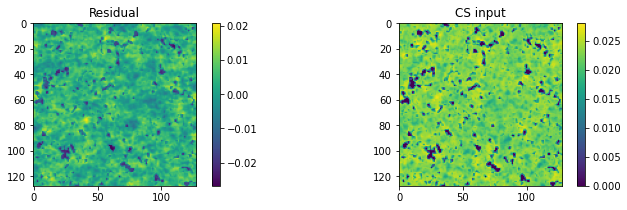

In [5]:
fig = plt.figure(figsize=(12,3))
ax = fig.add_subplot(1,2,1)
im0 = ax.imshow(np.real(res[20,:,:]))
ax.title.set_text('Residual')
fig.colorbar(im0,ax=ax)
clim=im0.properties()['clim']

ax = fig.add_subplot(1,2,2)
im = ax.imshow(indata_cs[20,:,:])
ax.title.set_text('CS input')
fig.colorbar(im,ax=ax)
clim=im0.properties()['clim']
plt.show()
#plt.savefig('images/residual_and_cs_input_difference')

plt.close()

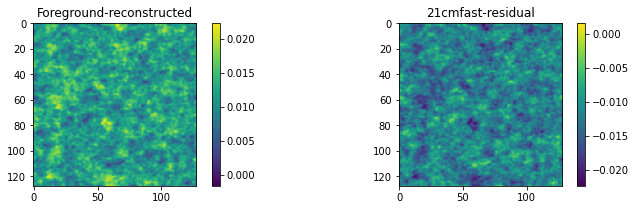

In [6]:
#fg - reconstructed
fig = plt.figure(figsize=(12,3))
ax = fig.add_subplot(1,2,1)
im0 = ax.imshow(np.real(rec[45,:,:]) - indata_fg[45,:,:])
ax.title.set_text('Foreground-reconstructed')
fig.colorbar(im0,ax=ax)
clim=im0.properties()['clim']
ax = fig.add_subplot(1,2,2)
im = ax.imshow(np.real(res[45,:,:]) - indata_cs[45,:,:])
ax.title.set_text('21cmfast-residual')
fig.colorbar(im,ax=ax)
clim=im0.properties()['clim']
plt.show()
plt.close()

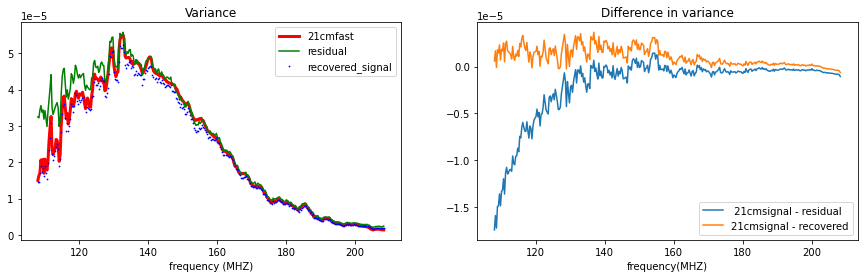

In [7]:
#variance
var_21 = np.zeros(no_sl)
var_res = np.zeros(no_sl)
recover = np.zeros(no_sl)
for i in range(no_sl):
    var_21[i] = np.var(indata_cs[i,:,:])
    var_res[i] = np.var(res[i,:,:])
    recover[i] = var_res[i] - np.var(noise[i])
    
       
#difference
diff = var_21 - var_res
diff2 = var_21 - recover

x = np.linspace(108,208.3,no_sl)


fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(1,2,1)
ax.title.set_text('Variance')
ax.set_xlabel('frequency (MHZ)')
im0 = ax.plot(x,var_21,'r',linewidth =3,label='21cmfast')
im1 = ax.plot(x,var_res,'g',label='residual')
im2 = ax.plot(x,recover, 'b.',markersize=1.5, label = 'recovered_signal')
ax.legend()

ax = fig.add_subplot(1,2,2)
im = ax.plot(x,diff, label =' 21cmsignal - residual')
im1 = ax.plot(x,diff2, label = '21cmsignal - recovered')
ax.title.set_text('Difference in variance')
ax.set_xlabel('frequency(MHZ)')
ax.legend()
plt.show()
#fig.savefig('images/Variance_noise100.png')
plt.close()


#save residual


In [8]:
max_10 = np.max(indata_cs[10,:,:])
min_10 = np.min(indata_cs[10,:,:])
#print(max_10)
#print(min_10)
#print(np.where(indata_cs[10,:,:]==max_10))
#print(np.where(indata_cs[10,:,:]==min_10))

In [9]:
print(indata_cs[10,124,70]) #hot spot for slice 10
print(indata_cs[10,0,87])    # cold spot for slice 10

0.02572932434082031
0.02218851661682129


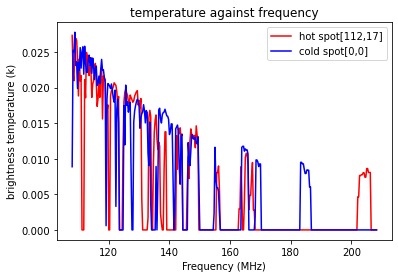

In [10]:
#plot hot, cold and a random point of the lightcone   
x = np.linspace(108,208.3,no_sl)
#list needs to be reversed
x = x[::1]

plt.plot(x,indata_cs[:,112,17],'r-',label='hot spot[112,17]')
plt.plot(x,indata_cs[:,0,0],'b-',label='cold spot[0,0]')
plt.xlabel('Frequency (MHz)')
plt.ylabel('brightness temperature (k)')
plt.title('temperature against frequency')
plt.legend()
#plt.savefig('images/lightcone_hot_and_cold_spot')

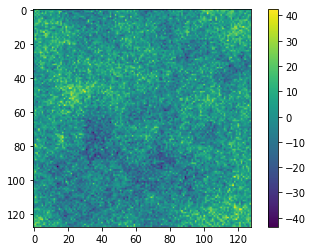

In [11]:
plt.imshow(indata_fg[10,:,:])
plt.colorbar()

In [12]:
max_10 = np.max(indata_fg[10,:,:])
min_10 = np.min(indata_fg[10,:,:])
print(max_10)
print(min_10)
print(np.where(indata_fg[10,:,:]==max_10))
print(np.where(indata_fg[10,:,:]==min_10))

42.35885466000929
-43.59423823766225
(array([103]), array([117]))
(array([92]), array([14]))


In [13]:
print(indata_fg[10,103,117])
print(indata_fg[10,92,14])

42.35885466000929
-43.59423823766225


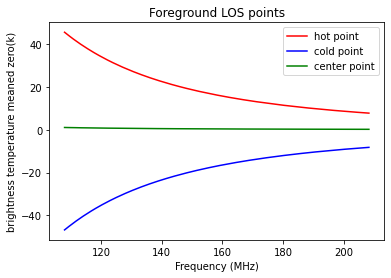

In [14]:
#plot hot, cold and a random point of the foreground  
x = np.linspace(108,208.3,no_sl)

plt.plot(x,indata_fg[:,103,117],'r-',label='hot point')
plt.plot(x,indata_fg[:,92,14],'b-',label='cold point')
plt.plot(x,indata_fg[:,64,64],'g-',label='center point')
plt.xlabel('Frequency (MHz)')
plt.ylabel('brightness temperature meaned zero(k)')
plt.title('Foreground LOS points')
plt.legend()
#plt.savefig('images/foreground_ LOS_Points')

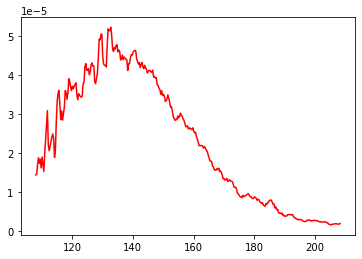

In [15]:
recover = np.zeros(no_sl)
for i in range(no_sl):
    recover[i] = var_res[i] - np.var(noise[i])
plt.plot(x,recover,'r')

### FastICA different noise removal

In [16]:
# Plot ica recovery of signal for different noise, 100 hours, 1,000 hours and 10,000 hours
# save results as fit file and then access file here to plot results

In [17]:
# Load all files
#noise
#100 hours
noise_100 = fits.getdata('fits_files/Noise_100.fits').T
#1000 hours of noise
noise_1000 = fits.getdata(r'fits_files/noise_108.000MHz_210.300MHz_SKA_SKA_central_area_EOR0_0128_3.0_1000h_K.fits')
#10000 hours
noise_10000  = fits.getdata('fits_files/Noise_10000.fits').T
#residuals
res_100 = fits.getdata('FastICA_different_noise/ZT0.msn_image_ncomp_3_FastICA_residual_100.fits')

res_1000 = fits.getdata('FastICA_different_noise/ZT0.msn_image_ncomp_3_FastICA_residual.fits')

res_10000 = fits.getdata('FastICA_different_noise/ZT0.msn_image_ncomp_3_FastICA_residual_10000.fits')

In [18]:
res = [res_100, res_1000, res_10000]
noi = [noise_100, noise_1000, noise_10000]
#variance
var_21 = np.zeros(no_sl)

var_res = np.zeros((no_sl,3))
recover = np.zeros((no_sl,3))
for m in range(3):
    residual = res[m]
    noise = noi[m]
    for i in range(no_sl):
        var_res[i,m] = np.var(residual[i,:,:])
        recover[i,m] = var_res[i,m] - np.var(noise[i])
        if m == 0:
            var_21[i] = np.var(indata_cs[i,:,:])
            var_res[i,m] = np.var(residual[i,:,:]) * 0.01
            recover[i,m] = var_res[i,m] - np.var(noise[i]) * 0.01
 

In [19]:
print(np.shape(res[0]))

(342, 128, 128)


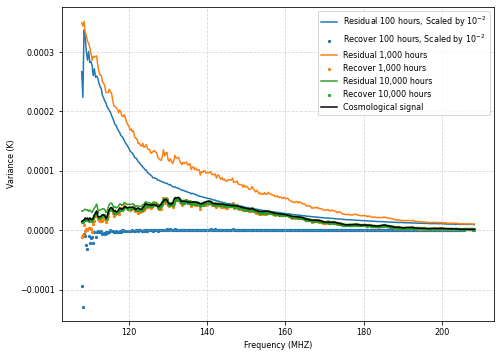

In [20]:
folder = 'Submit/'
#create figure
x = np.linspace(108,208.3,no_sl)
plt.figure(figsize=(7,5))
plt.rcParams.update({'font.size' : 8})


colours = ['#1f77b4', '#ff7f0e','#2ca02c']
labels  = [r'Residual 100 hours, Scaled by $10^{-2}$', 'Residual 1,000 hours', 'Residual 10,000 hours']  
labels_recover  = [r'Recover 100 hours, Scaled by $10^{-2}$', 'Recover 1,000 hours', 'Recover 10,000 hours']  

#var_res[:,0] = var_res[:,0]
#recover[:,0] = recover[:,0]


#plot residual with different noise
for i in range(3):
    plt.plot(x,var_res[:,i], color = colours[i], label = labels[i])
    plt.scatter(x,recover[:,i], color = colours[i],label = labels_recover[i], s=5)
    
plt.plot(x,var_21[:], color ='black', label= r'Cosmological signal')
plt.xlabel('Frequency (MHZ)')
plt.ylabel('Variance (K)')
#plt.title('variance against frequency')
plt.legend()
plt.grid(True, linestyle= '--', alpha = 0.5)
plt.tight_layout()
#plt.savefig( folder +'FastICA_with_different_noise.png')